In [2]:
import pandas as pd
from pathlib import Path
from scipy import stats

from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import learning_curve,RepeatedKFold

from sklearn.pipeline import make_pipeline
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from imblearn import over_sampling as ovs
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer,quantile_transform,PowerTransformer


%matplotlib inline

In [132]:
sns.set_context(context="paper")


In [166]:

#dataframe final
df_final = pd.read_csv("../data/DF_train15_skempiAB_modeller_final.csv",index_col=0)

#drop_ddg = (df_final.ddG_exp.abs() > 6)
#df_final = df_final.loc[-drop_ddg]

pdb_names = df_final.index
features_names = df_final.drop('ddG_exp',axis=1).columns


In [165]:
#df_final[(df_final.ddG_exp.abs() > 6)]

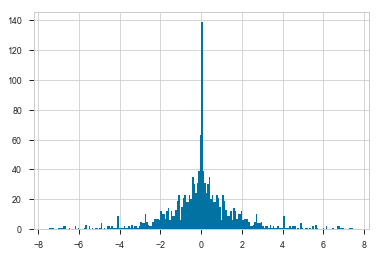

In [163]:
df_final.ddG_exp.hist(bins=200)

In [5]:
X = df_final.drop('ddG_exp',axis=1).astype(float)
y = df_final['ddG_exp']

In [6]:
# binned split
bins = np.linspace(0, len(X), 200)
y_binned = np.digitize(y, bins)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y_binned,random_state=1)                                                    

In [131]:
stats.t?

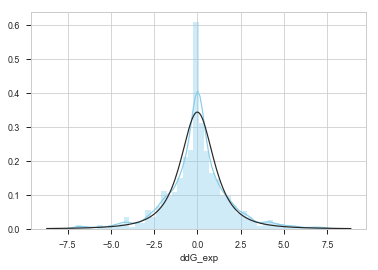

In [130]:
#sns.distplot( y_test , fit=stats.laplace,color="red", label="ddG_exp_test")
sns.distplot( y_train , fit=stats.t,color="skyblue", label="ddG_exp_train")

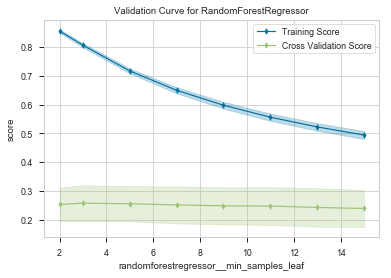

In [67]:
import numpy as np

from yellowbrick.model_selection import ValidationCurve

#1)
selector = VarianceThreshold()

#2)
rf_model = RandomForestRegressor(random_state=1212,n_estimators=100)
#3) Crear pipeline


pipeline1 = make_pipeline(selector,rf_model)

#regr_trans = TransformedTargetRegressor(
#    regressor=pipeline1, transformer=PowerTransformer())

cv = RepeatedKFold(n_splits=5,n_repeats=2,random_state=13)

# Extract the instances and target
viz = ValidationCurve(
    pipeline1, njobs=-1,param_name="randomforestregressor__min_samples_leaf",
    param_range=[2,3,5,7,9,11,13,15], cv=cv, scoring="r2"
)
#plt.ylim(0,0.6)
# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof()


In [3]:
#1)
scale = RobustScaler()
selector = VarianceThreshold()
#2)
rf_model = RandomForestRegressor()
#3) Crear pipeline


pipeline1 = make_pipeline(scale,selector,rf_model)
# grid params
param_grid = {
    'randomforestregressor__bootstrap': [True],
    'randomforestregressor__max_depth': [7],
    'randomforestregressor__max_features': ['sqrt'],
    'randomforestregressor__max_leaf_nodes':[20],
    'randomforestregressor__min_samples_leaf': [9],
    'randomforestregressor__min_samples_split': [5],
    'randomforestregressor__n_estimators': [100],
    'randomforestregressor__random_state':[1212],
    'variancethreshold__threshold':[0.,0.001] }

cv = RepeatedKFold(n_splits=5,n_repeats=10,random_state=13)

# Instantiate the grid search model
grid1 = GridSearchCV(pipeline1, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','r2'],
                        refit='r2',return_train_score=True)

grid1.fit(X_train,y_train)

NameError: name 'X_train' is not defined

In [97]:
# index of best scores
rmse_bestCV_test_index = grid1.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid1.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid1.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid1.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid1.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid1.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid1.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid1.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid1.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid1.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid1.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid1.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(r2_bestCV_train_score-r2_bestCV_test_score)
print("",grid1.best_params_)
y_test_pred = grid1.best_estimator_.predict(X_test)
y_train_pred = grid1.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test)[0][1]))
print('R2 test',r2_score(y_test,y_test_pred))
print('R2 train',r2_score(y_train,y_train_pred))

CV test RMSE 1.683744 +/- 0.571451
CV train RMSE 1.453033 +/- 0.249480
CV test r2 0.204091 +/- 0.040775
CV train r2 0.409701 +/- 0.010283
0.20560989404704552
 {'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': 7, 'randomforestregressor__max_features': 'sqrt', 'randomforestregressor__max_leaf_nodes': 20, 'randomforestregressor__min_samples_leaf': 9, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 100, 'randomforestregressor__random_state': 1212, 'variancethreshold__threshold': 0.0}

RMSE for test dataset: 1.76
RMSE for train dataset: 1.48
pearson corr  0.428245
R2 test 0.17337160006284946
R2 train 0.38642283627500507


In [171]:
CV test RMSE 0.732178 +/- 0.267910
CV train RMSE 0.634067 +/- 0.118619
CV test r2 0.189206 +/- 0.040756
CV train r2 0.393611 +/- 0.010416
0.20440580857781124

0.300056355076

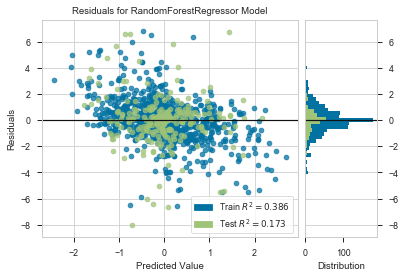

In [98]:
visualizer = ResidualsPlot(grid1.best_estimator_)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

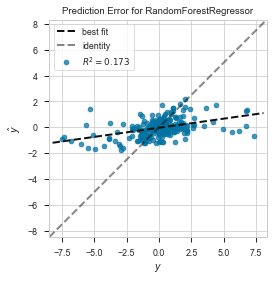

In [99]:
perror = PredictionError(grid1.best_estimator_)

perror.fit(X_train, y_train)  # Fit the training data to the visualizer
perror.score(X_test, y_test)  # Evaluate the model on the test data
g = perror.poof() 

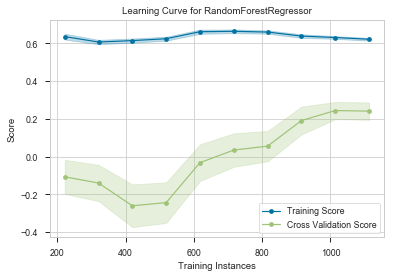

In [44]:
viz = LearningCurve(grid1.best_estimator_, cv=cv, n_jobs=-1,scoring='r2',train_sizes=np.linspace(0.2, 1.0, 10))
viz.fit(X, y)
#plt.ylim(0,-4)
viz.poof()

In [174]:
final_rf = grid1.best_estimator_.fit(X,y)

In [175]:
# save final model

joblib.dump(final_rf, 'RFmodel_train15skempiAB_FINAL.pkl')

['RFmodel_train15skempiAB_FINAL.pkl']

Text(4.5, -0.5, 'RMSE = 0.755')

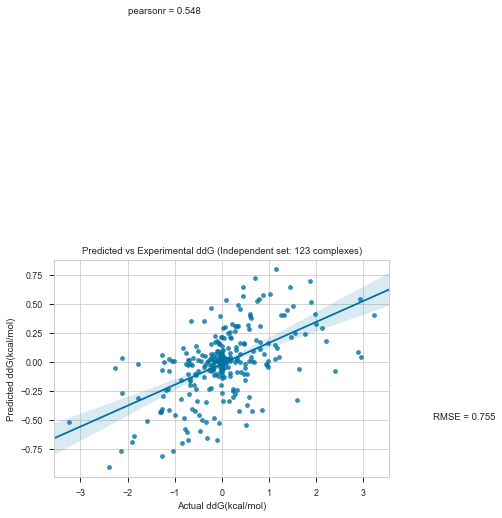

In [177]:
rmse_test = np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 3)
df_pred = pd.DataFrame({"Predicted ddG(kcal/mol)": y_test_pred, "Actual ddG(kcal/mol)": y_test.values})
pearsonr_test = round(df_pred.corr().iloc[0,1],3)

g = sns.regplot(x="Actual ddG(kcal/mol)", y="Predicted ddG(kcal/mol)",data=df_pred)
plt.title("Predicted vs Experimental ddG (Independent set: 123 complexes)")

plt.text(-2,3,"pearsonr = %s" %pearsonr_test)
plt.text(4.5,-0.5,"RMSE = %s" %rmse_test)

#plt.savefig("RFmodel_300_testfit.png",dpi=600)

Text(0.5, 1.0, 'Predicted vs Experimental ddG (Train set: 492 complexes)')

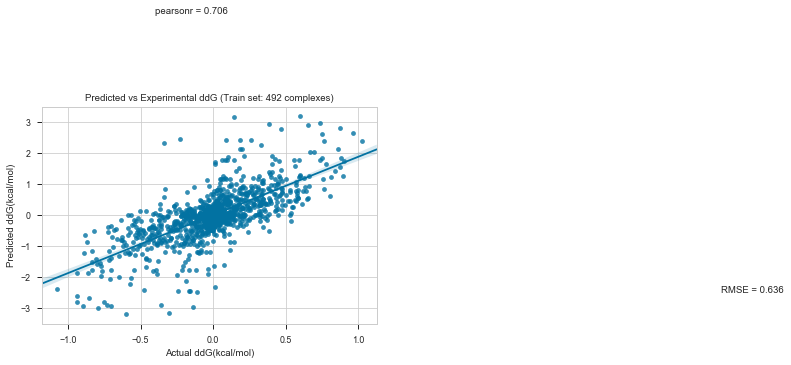

In [179]:
df_train_pred = pd.DataFrame({"Predicted ddG(kcal/mol)": y_train, "Actual ddG(kcal/mol)": y_train_pred})
pearsonr_train = round(df_train_pred.corr().iloc[0,1],3)
rmse_train = np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 3)

g = sns.regplot(x="Actual ddG(kcal/mol)", y="Predicted ddG(kcal/mol)",data=df_train_pred)

plt.text(-0.4,6.5,"pearsonr = %s" %pearsonr_train)
plt.text(3.5,-2.5,"RMSE = %s" %rmse_train)
plt.title("Predicted vs Experimental ddG (Train set: 492 complexes)")
#plt.savefig("RFmodel_300_trainfit.png",dpi=600)


In [180]:
rf_model = grid1.best_estimator_.named_steps["randomforestregressor"]
importances = list(rf_model.feature_importances_)
feature_list = df_final.columns
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: backbone_hbond_change Importance: 0.1002
Variable: intraclashes_energy_2_change Importance: 0.1
Variable: vdw_clash_change     Importance: 0.0928
Variable: sidechain_hbond_change Importance: 0.0511
Variable: torsional_clash_wt   Importance: 0.0493
Variable: polar_change         Importance: 0.03
Variable: disulfide_wt         Importance: 0.029
Variable: water_bridge_wt      Importance: 0.0265
Variable: hydrophobic_change   Importance: 0.0241
Variable: entropy_sidechain_change Importance: 0.0225
Variable: electrostatic_kon_wt Importance: 0.0211
Variable: intraclashes_energy_1_change Importance: 0.019
Variable: electrostatics_change Importance: 0.0185
Variable: van_der_waals_wt     Importance: 0.0177
Variable: interface_residues_clashing_change Importance: 0.0175
Variable: sidechain_hbond_wt   Importance: 0.0175
Variable: intraclashes_energy_1_wt Importance: 0.0166
Variable: clash_change         Importance: 0.0164
Variable: disulfide_change     Importance: 0.0164
Variable: van_d

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [192]:
rf_model.feature_importances_[idx_features]

array([0.10018873, 0.10003764, 0.09280383, 0.05114523, 0.04925349,
       0.02999234, 0.02904035, 0.02650227, 0.02409631, 0.02251165,
       0.02108252, 0.01895253, 0.01846813, 0.0176982 , 0.01748447,
       0.017481  , 0.01658042, 0.01642932, 0.01637515, 0.01625201,
       0.0151773 , 0.01504132, 0.01503954, 0.01498061, 0.01464421,
       0.01459716, 0.01437429, 0.01267008, 0.01197128, 0.01138991,
       0.01101648, 0.01045805, 0.01019026, 0.00955838, 0.00939065,
       0.00893419, 0.00889534, 0.00840446, 0.00838856, 0.00806242,
       0.0077283 , 0.00772304, 0.00681433, 0.00666166, 0.00622122,
       0.00543836, 0.00434386, 0.00319832, 0.00306715, 0.00254983,
       0.00233446, 0.00226309, 0.00218661, 0.00212628, 0.00055806,
       0.0005321 , 0.00045653, 0.00023669, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

Text(0.5, 0, 'Feature importance')

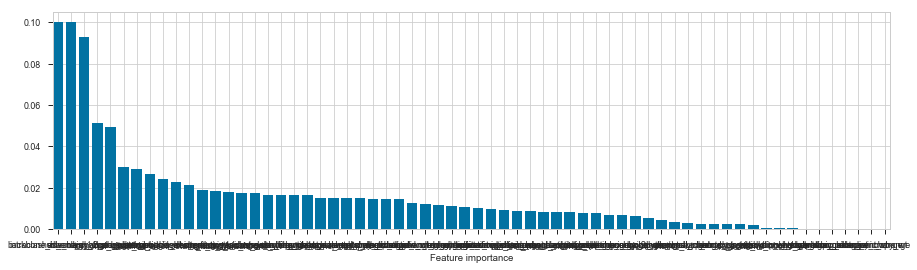

In [193]:
idx_features = rf_model.feature_importances_.argsort()[::-1]
plt.figure(figsize=(15,4))

plt.bar(np.arange(len(idx_features)), rf_model.feature_importances_[idx_features])
plt.xticks(range(len(feature_list)),feature_list[idx_features])
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel(u"Feature importance")
#plt.savefig("RFmodel_300_50features",dpi=600,bbox_inches="tight")